## 1 . Imports

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

## 2. Data Cleaning 

In [2]:
# reading data
dataset = pd.read_csv("Time_series_analysis_and_forecast_DATASET.csv")

In [3]:
dataset.tail()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
92011,2021-02-28 19:00:00,24.3,449.63625,5.4848,117.925
92012,2021-02-28 20:00:00,24.3,815.59975,5.4848,87.880
92013,2021-02-28 21:00:00,24.3,745.12325,5.4848,62.060
92014,2021-02-28 22:00:00,24.3,694.95150,5.4848,62.000
92015,2021-02-28 23:00:00,24.3,714.69630,5.4848,62.955


In [4]:
# no null values in dataset
dataset.isna().sum()

FullDate     0
Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

In [5]:
dataset.shape

(92016, 5)

In [6]:
# parsing dates
dataset['FullDate'] = pd.to_datetime(dataset['FullDate'], format = '%Y-%m-%d %H:%M:%S')

In [7]:
# chacking dtypes of the dataframe
dataset.dtypes

FullDate     datetime64[ns]
Tmax                float64
SysLoad             float64
GasPrice            float64
ElecPrice           float64
dtype: object

In [8]:
# reanamig colums
new_name = {
    'FullDate' : 'ds',
    'ElecPrice' : 'y', 
}

In [9]:
dataset.rename(columns=new_name, inplace = True)

In [10]:
#sampling data
sampled_df = dataset

In [11]:
# setting index as ds
sampled_df.set_index('ds', inplace = True)

In [12]:
# resampling data into days
sampled_df = sampled_df.resample('D').sum()

In [13]:
sampled_df.head(4)

,Tmax,SysLoad,GasPrice,y
ds,,,,
2010-09-01,379.2,41565.380,88.56,2751.700
2010-09-02,369.6,38898.990,88.56,570.810
2010-09-03,439.2,41665.760,106.80,504.975
2010-09-04,328.8,35638.085,81.36,502.275


In [14]:
# calculating critical values
result = adfuller(sampled_df['GasPrice'])
critical_gas = result[4]
print(f"   10%: {critical_gas['10%']}")
print(f"   5%: {critical_gas['5%']}")
print(result[1])

   10%: -2.5671743978048323
   5%: -2.8622996992165364
0.045027212884625106


In [15]:
result1 = adfuller(sampled_df['SysLoad'])
print(result1[1])

0.00425372550457402


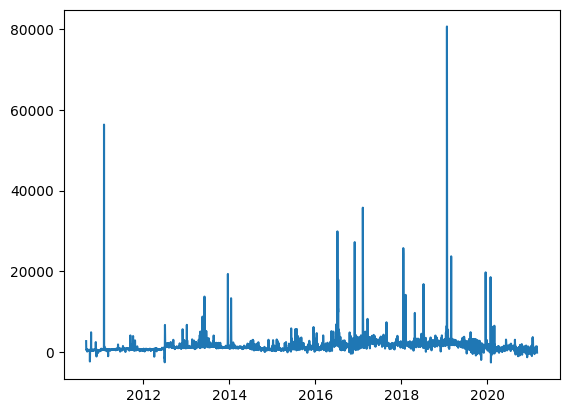

In [16]:
plt.plot(sampled_df.index, sampled_df['y'])

In [17]:
# reset index for time series
sample = sampled_df.reset_index(False)
sample.shape

(3834, 5)

In [18]:
# splitting data into training and test set.
train = sample.iloc[:2757]
test = sample.iloc[2758:]

## 3. Univariate modeling

In [19]:
# selecting two columns for univariate time series
train_df = train[['ds', 'y']]
test_df = test['ds']

In [20]:
test_df = pd.DataFrame(test_df)

In [21]:
# fitting model
m = Prophet()
m.fit(train_df)

16:42:10 - cmdstanpy - INFO - Chain [1] start processing
16:42:10 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# creating forecast
forecast = m.predict(test_df)

In [23]:
forecast.shape

(1076, 19)

In [24]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-21,2690.146479,498.076256,5079.208688,2690.146479,2690.146479,-2.999529,-2.999529,-2.999529,159.371311,159.371311,159.371311,-162.370841,-162.370841,-162.370841,0.0,0.0,0.0,2687.146950
1,2018-03-22,2690.953457,441.929792,5176.614509,2690.953457,2690.953457,95.220809,95.220809,95.220809,257.123036,257.123036,257.123036,-161.902227,-161.902227,-161.902227,0.0,0.0,0.0,2786.174266
2,2018-03-23,2691.760435,149.001270,4801.431037,2691.760435,2691.760435,-113.426059,-113.426059,-113.426059,50.278212,50.278212,50.278212,-163.704271,-163.704271,-163.704271,0.0,0.0,0.0,2578.334376
3,2018-03-24,2692.567413,-181.795358,4601.674195,2692.567413,2692.567413,-438.985887,-438.985887,-438.985887,-271.450904,-271.450904,-271.450904,-167.534983,-167.534983,-167.534983,0.0,0.0,0.0,2253.581526
4,2018-03-25,2693.374391,-110.940837,4408.143535,2693.374391,2693.374391,-515.824457,-515.824457,-515.824457,-342.739719,-342.739719,-342.739719,-173.084738,-173.084738,-173.084738,0.0,0.0,0.0,2177.549934


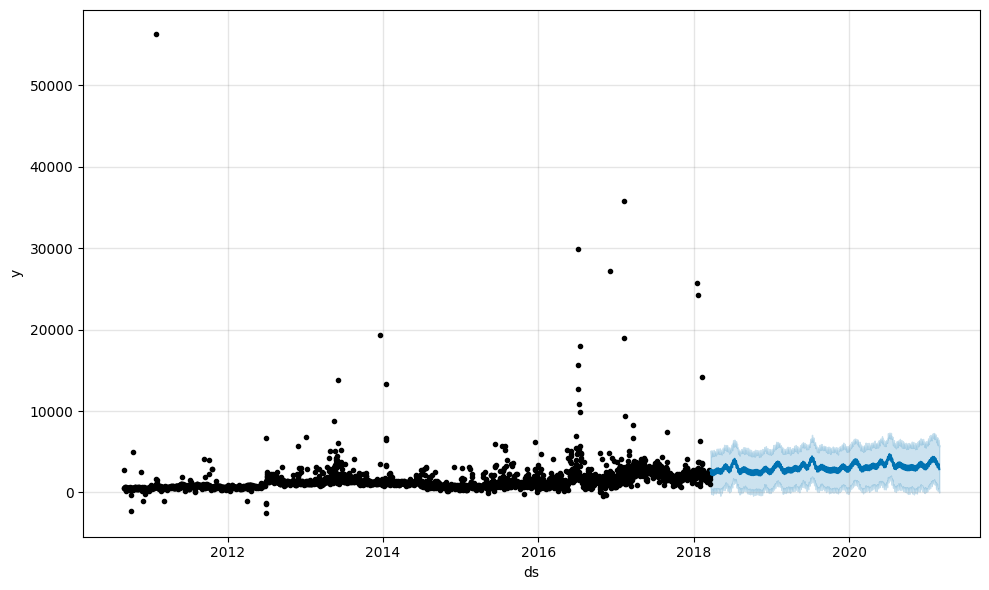

In [25]:
fig1 = m.plot(forecast)

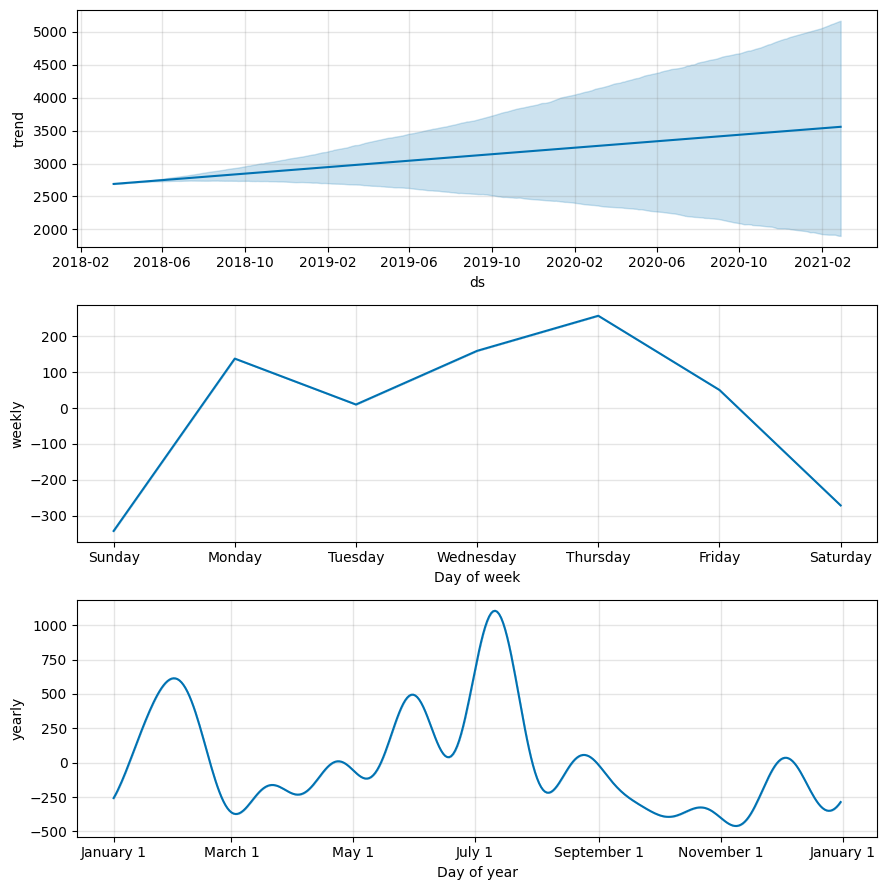

In [26]:
fig2 = m.plot_components(forecast)
# July has the highest value of seasonality in Univariate series.

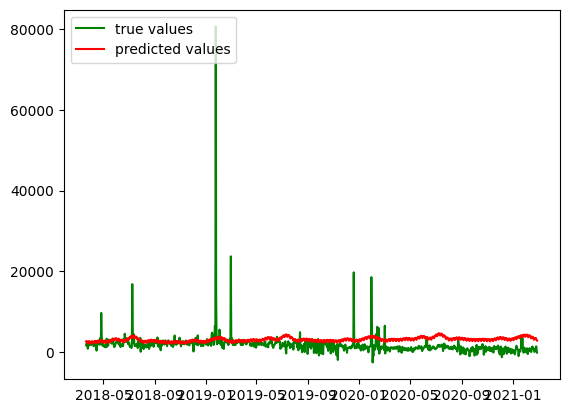

In [27]:
plt.plot(forecast['ds'], test['y'] , color = 'green', label = 'true values')
plt.plot(forecast['ds'], forecast['yhat'], color = 'red', label = 'predicted values')
plt.legend(loc = 'upper left')
plt.show()

In [28]:
# defining function to calculate RMSE values. 

def RMS(true_val , pred_val):
    MAE_SQR = 0
    for i in range(len(true_val)):
        MAE_SQR = MAE_SQR + np.square(true_val[i] - pred_val[i])
    RMSE = np.sqrt((1/len(true_val))*MAE_SQR)
    print('RMSE valu = ', RMSE)


In [29]:
true_val = np.array(test.y)
pred_val = np.array(forecast.yhat)

RMS(true_val, pred_val)

RMSE valu =  3215.546112862678


In [30]:
# calculating MAPE

def MAPE(actual_val , forecast_value ):
    n = 0
    for i in range(len(actual_val)):
            n = n + (( (actual_val[i] - forecast_value[i]) / actual_val[i] )*100)
    MAPE_val = (( 1 / len(actual_val) ) * n)
    print('MAPE = ', MAPE_val)
            

In [31]:
MAPE(true_val , pred_val)

MAPE =  137.80577573745157


## 4. Multi Variate

In [32]:
# train data and test for Multi variate

train_df2 = train
test_df2 = test.drop(labels = ['y'], axis = 1 , inplace = False)

In [33]:
# multivariate series fitting the model

mv = Prophet()
mv.add_regressor('SysLoad',standardize=False),
mv.add_regressor('Tmax',standardize=False),
mv.add_regressor('GasPrice',standardize=False),
mv.fit(train_df2)

16:42:12 - cmdstanpy - INFO - Chain [1] start processing
16:42:12 - cmdstanpy - INFO - Chain [1] done processing
16:42:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:42:13 - cmdstanpy - INFO - Chain [1] start processing
16:42:22 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
forecast2 = mv.predict(test_df2)

In [35]:
forecast2.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,GasPrice,GasPrice_lower,GasPrice_upper,SysLoad,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-21,-1270.714049,-297.231736,4262.646388,-1270.714049,-1270.714049,2964.056767,2964.056767,2964.056767,262.510959,...,42.396011,42.396011,42.396011,-36.350285,-36.350285,-36.350285,0.0,0.0,0.0,1961.851792
1,2018-03-22,-1270.044292,668.588787,5118.585547,-1270.044292,-1270.044292,2964.056767,2964.056767,2964.056767,1079.887354,...,145.098980,145.098980,145.098980,-31.407480,-31.407480,-31.407480,0.0,0.0,0.0,2887.531114
2,2018-03-23,-1269.374535,434.464596,4756.707543,-1269.374535,-1269.374535,2896.823882,2896.823882,2896.823882,1019.509979,...,-44.775169,-44.775169,-44.775169,-30.575786,-30.575786,-30.575786,0.0,0.0,0.0,2571.540755
3,2018-03-24,-1268.704778,-915.434750,3645.418163,-1268.704778,-1268.704778,2628.067336,2628.067336,2628.067336,212.099120,...,-116.872515,-116.872515,-116.872515,-33.601561,-33.601561,-33.601561,0.0,0.0,0.0,1420.918184
4,2018-03-25,-1268.035021,-1389.097165,3292.249202,-1268.035021,-1268.035021,2624.917435,2624.917435,2624.917435,-288.073037,...,-68.258871,-68.258871,-68.258871,-40.130441,-40.130441,-40.130441,0.0,0.0,0.0,960.375854


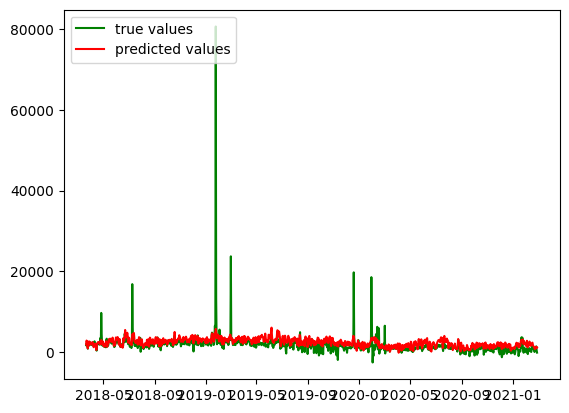

In [36]:
plt.plot(forecast2['ds'], test['y'] , color = 'green', label = 'true values')
plt.plot(forecast2['ds'], forecast2['yhat'], color = 'red', label = 'predicted values')
plt.legend(loc = 'upper left')
plt.show()

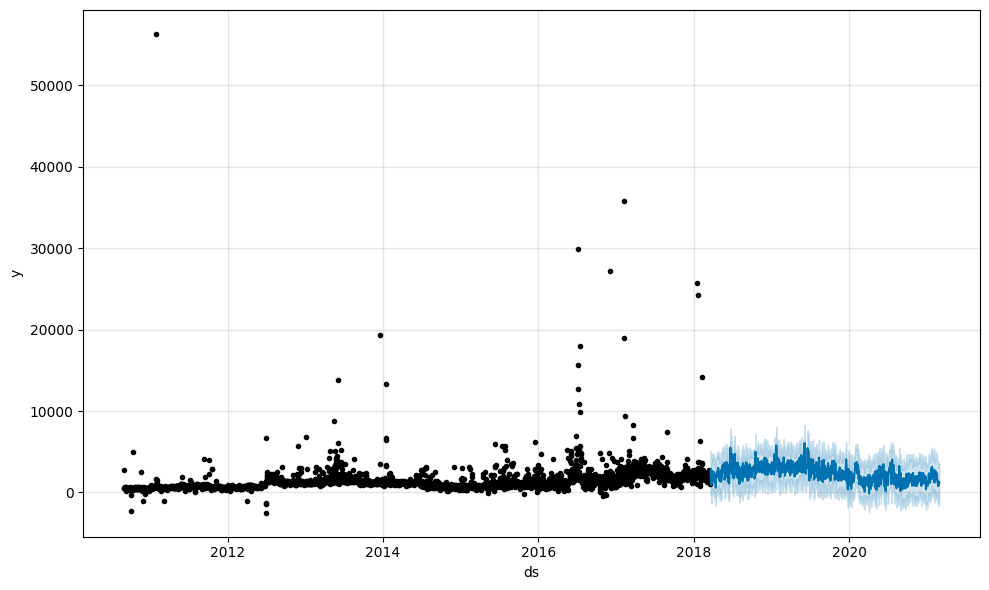

In [37]:
fig3= mv.plot(forecast2)

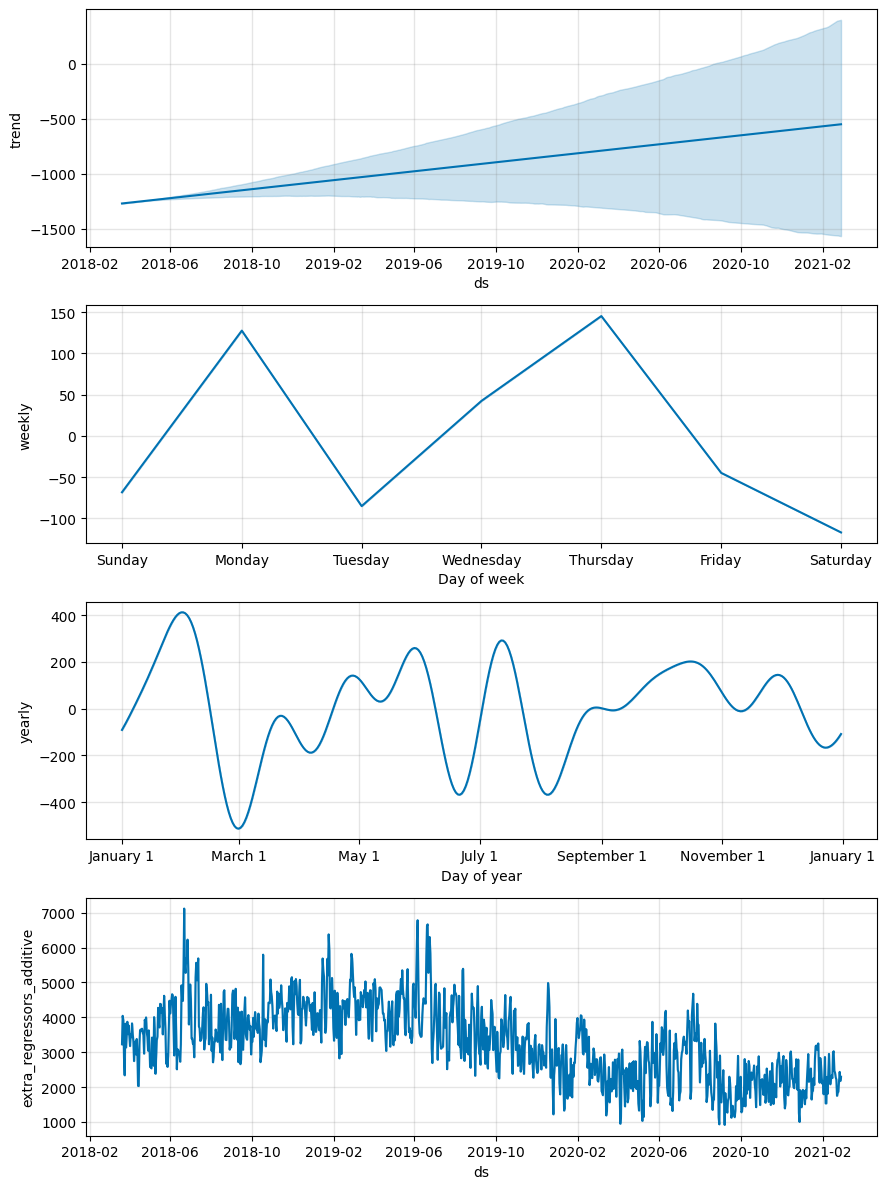

In [38]:
fig4 = mv.plot_components(forecast2)
# Highest Value of daily seasonlatiy in Multivariate model on  is "Thursday" 

In [39]:
# calculating RMSE for Multivaraite 
true = np.array(test.y)
pred = np.array(forecast2.yhat)
RMS(true , pred)

RMSE valu =  2704.643885661537


In [40]:
# Calculating MAPE for Multivariate

MAPE(true , pred)

MAPE =  66.9492742282996


In [41]:
# splitting train and test data for data without Tmax

train_df3 = train.drop(labels = ['Tmax'] , axis = 1 , inplace=False )
test_df3 = test.drop(labels = ['Tmax', 'y'] , axis = 1 , inplace=False )

In [42]:
model = Prophet()
model.add_regressor('SysLoad',standardize=False),
model.add_regressor('GasPrice',standardize=False),
model.fit(train_df3)

16:42:25 - cmdstanpy - INFO - Chain [1] start processing
16:42:25 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
forecast3 = model.predict(test_df3)

In [44]:
# calculating MAPE for 3rd forecasr question 20

true_val = np.array(test.y)
predict_value = np.array(forecast3.yhat)

MAPE(true_val, predict_value)

MAPE =  81.93243111797433
